In [234]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

## Step 1: Read and understand the data

In [235]:
country_data = pd.read_csv('Country-data.csv')

In [236]:
country_data.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [237]:
country_data.shape

(167, 10)

In [238]:
country_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [239]:
country_data.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


## Step 2: Clean and visualize the data

#### Checking missing values

In [240]:
#checking missing data
country_data.isnull().sum(axis=0)

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

#### Checking outliers

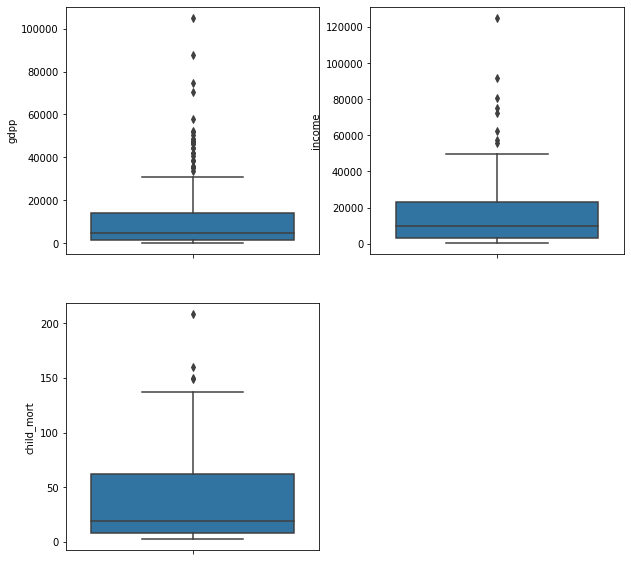

In [241]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
sns.boxplot(y=country_data['gdpp'])
plt.subplot(2,2,2)
sns.boxplot(y=country_data['income'])
plt.subplot(2,2,3)
sns.boxplot(y=country_data['child_mort'])
plt.show()

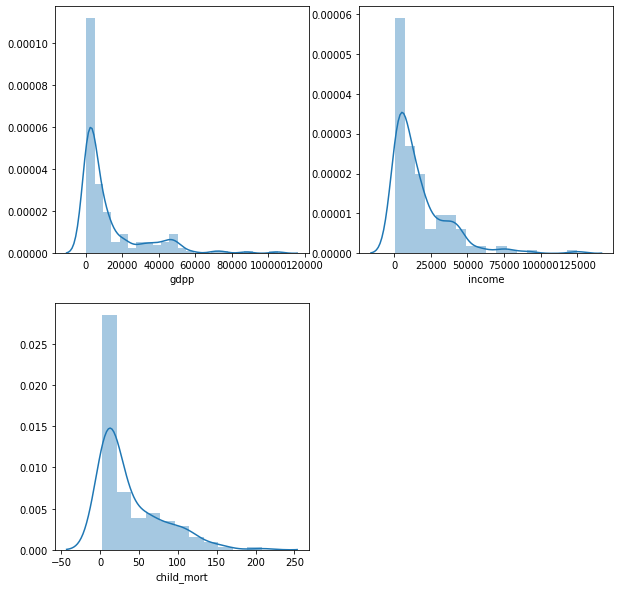

In [242]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
sns.distplot(country_data['gdpp'])
plt.subplot(2,2,2)
sns.distplot(country_data['income'])
plt.subplot(2,2,3)
sns.distplot(country_data['child_mort'])
plt.show()

#### We do see some outliers. As the data points are less so we will not be removing any outliers. The solution demands the name of ocuntries that need financial aid, and deleting outliers might delete the country which is in need. 

#### Therefore, we are soft capping the data. 
- All points lying below 0.01 percentile will be assigned the value of 0.01 percentile
- All the points lying above 0.99 percentile will be assigned the value of 0.99 percentile


In [243]:
#capping the data for gdpp and income
for col in ['gdpp','income']:
    percentiles = country_data[col].quantile([0.01,0.99]).values
    country_data[col][country_data[col] <= percentiles[0]] = percentiles[0]
    country_data[col][country_data[col] >= percentiles[1]] = percentiles[1]
    

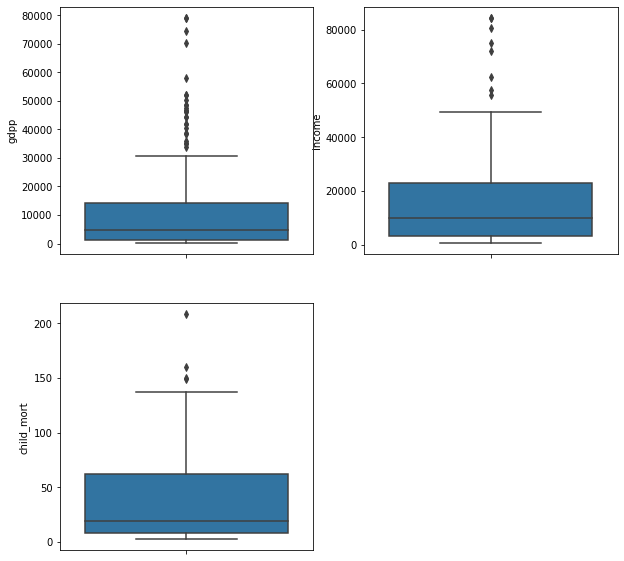

In [244]:
#check again the box plots
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
sns.boxplot(y=country_data['gdpp'])
plt.subplot(2,2,2)
sns.boxplot(y=country_data['income'])
plt.subplot(2,2,3)
sns.boxplot(y=country_data['child_mort'])
plt.show()

#### As per Data Dictionary, Exports, Imports and Health are. Given as %age of the Total GDP. Therefore, converting them to absolute values

In [245]:
country_data['exports'] = country_data['exports']*country_data['gdpp']/100
country_data['imports'] = country_data['imports']*country_data['gdpp']/100
country_data['health'] = country_data['health']*country_data['gdpp']/100

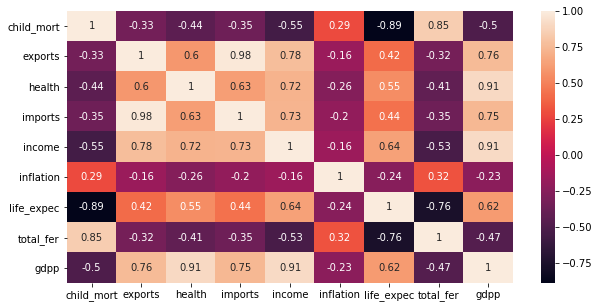

In [246]:
plt.figure(figsize=[10,5]) 
corrmat = country_data.corr()
sns.heatmap(corrmat,annot=True)

There are few features that are highly correlated and PCA will help in reducing the correlated features.

In [247]:
 country_data[['country','gdpp']].sort_values(by='gdpp').head()

,country,gdpp
26,Burundi,331.62
88,Liberia,331.62
37,"Congo, Dem. Rep.",334.00
112,Niger,348.00
132,Sierra Leone,399.00


In [248]:
country_data[['country','income']].sort_values(by='income').head()

,country,income
37,"Congo, Dem. Rep.",742.24
88,Liberia,742.24
26,Burundi,764.00
112,Niger,814.00
31,Central African Republic,888.00


In [249]:
country_data[['country','child_mort']].sort_values(by='child_mort',ascending = False).head()

,country,child_mort
66,Haiti,208.0
132,Sierra Leone,160.0
32,Chad,150.0
31,Central African Republic,149.0
97,Mali,137.0


Based on initial analysis looks like Libera, Centrail African Republic, Niger, Burundi and  Sierra Leone are the countries which have atmost 2 concerning factors of low gdpp, low income and high child mortality rate.


##  Step 3: Prepare the data for modeling

#### Step 3.1: Standarising data

In [250]:
X = country_data.drop('country',axis=1)
y = country_data['country']
X.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,90.2,55.30,41.9174,248.297,1610.0,9.44,56.2,5.82,553.0
1,16.6,1145.20,267.8950,1987.740,9930.0,4.49,76.3,1.65,4090.0
2,27.3,1712.64,185.9820,1400.440,12900.0,16.10,76.5,2.89,4460.0
3,119.0,2199.19,100.6050,1514.370,5900.0,22.40,60.1,6.16,3530.0
4,10.3,5551.00,735.6600,7185.800,19100.0,1.44,76.8,2.13,12200.0


In [251]:
len(y)

167

In [252]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X)
X.head()

,0,1,2,3,4,5,6,7,8
0,1.291532,-0.459906,-0.575130,-0.482878,-0.851772,0.157336,-1.619092,1.902882,-0.702314
1,-0.538949,-0.389039,-0.444888,-0.345299,-0.387025,-0.312347,0.647866,-0.859973,-0.498775
2,-0.272833,-0.352143,-0.492098,-0.391751,-0.221124,0.789274,0.670423,-0.038404,-0.477483
3,2.007808,-0.320507,-0.541305,-0.382739,-0.612136,1.387054,-1.179234,2.128151,-0.531000
4,-0.695634,-0.102567,-0.175293,0.065837,0.125202,-0.601749,0.704258,-0.541946,-0.032079


In [253]:
round(X.describe(),2)

,0,1,2,3,4,5,6,7,8
count,167.00,167.00,167.00,167.00,167.00,167.00,167.00,167.00,167.00
mean,-0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-0.89,-0.46,-0.59,-0.50,-0.90,-1.14,-4.34,-1.19,-0.72
25%,-0.75,-0.43,-0.55,-0.45,-0.75,-0.57,-0.59,-0.76,-0.66
50%,-0.47,-0.35,-0.41,-0.34,-0.39,-0.23,0.29,-0.36,-0.47
75%,0.59,0.01,-0.04,0.11,0.33,0.28,0.70,0.62,0.07
max,4.22,8.54,4.39,8.38,3.77,9.13,1.38,3.01,3.82


#### The data has been scaled with standard deviation as 1 and mean as 0

#### Step 3.2: Perform PCA and select the number of components

Let is first understand the need of PCA.
- If we drop any feature, we will be losing informations. Therefore, we will be using PCA to reduce the dimensions before applying any model.
- We need to apply KMeans model and for any distance based algorithm there is a drawback.
- As we increase the number of dimensions the data points start looking equidistant from the cluster center.
- In such case, K-Means clustering  will fail to assign the data to its nearest cluster. Therefore, we will be using PCA to reduce the dimensions.

First we need to reduce the dimensions so that K-Means clustering can work.


In [254]:
pca = PCA(svd_solver='randomized',random_state = 42)

In [255]:
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
    svd_solver='randomized', tol=0.0, whiten=False)

Lets see how the Principal components look like

In [256]:
pca.components_

array([[-0.3174589 ,  0.34390378,  0.35146853,  0.34689139,  0.38710678,
        -0.14392247,  0.34537354, -0.30414004,  0.39336611],
       [ 0.48098244,  0.3910367 ,  0.15749087,  0.35994648,  0.15012086,
         0.22592693, -0.36271316,  0.46466432,  0.20081916],
       [-0.15641165, -0.02619052, -0.07952738, -0.07129193,  0.13324576,
         0.9479718 ,  0.19969172, -0.08442782,  0.00570121],
       [-0.12681025,  0.44721909, -0.6319461 ,  0.44746642, -0.09111044,
        -0.02561547, -0.01999698, -0.19024515, -0.37253431],
       [ 0.21924593, -0.05501534, -0.10748279, -0.1664661 ,  0.38051577,
         0.02301728, -0.57762547, -0.64720823,  0.10857854],
       [-0.02168395, -0.02953868, -0.49736759, -0.27873095,  0.66708025,
        -0.1659441 ,  0.18572035,  0.39011502,  0.11990219],
       [ 0.76060482, -0.02012101, -0.06685991,  0.01700257, -0.02112309,
        -0.02328908,  0.58276378, -0.27301341, -0.03431629],
       [-0.01587009,  0.16976615, -0.37792809, -0.18515589, -0

Now we look at the explained variance ratio for each component

In [257]:
pca.explained_variance_ratio_

array([0.60260472, 0.17426957, 0.09906558, 0.06310147, 0.02498916,
       0.02353705, 0.00935676, 0.00239678, 0.00067891])

- 46% of the variance is explained by Principal component 1.
- 17% of variance is explained by Principal component 2.


We need to capture around 95% of the variance. To calculate the number of Principal components required, we will be creating a scree plot

In [258]:
var_cummu = np.cumsum(pca.explained_variance_ratio_)

In [259]:
var_cummu

array([0.60260472, 0.77687429, 0.87593986, 0.93904134, 0.9640305 ,
       0.98756755, 0.99692431, 0.99932109, 1.        ])

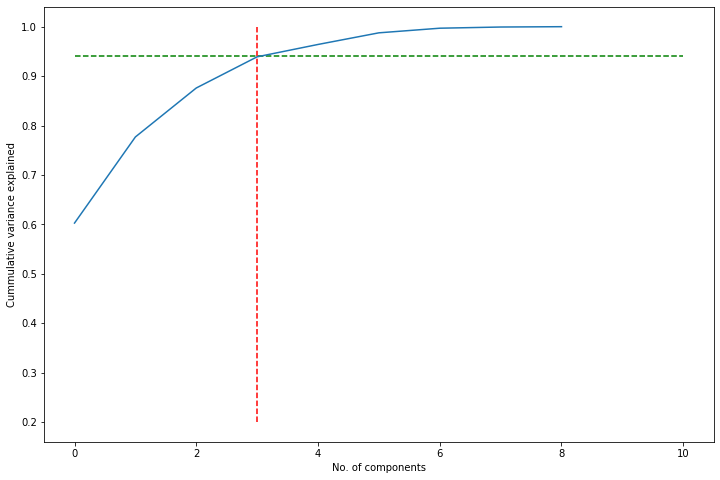

In [260]:
fig = plt.figure(figsize=(12,8))
plt.vlines(x=3,ymax=1,ymin=0.2,colors = 'r',linestyle = "--")
plt.hlines(y=0.94,xmax=10,xmin=0,colors = 'g',linestyle = "--")
plt.plot(var_cummu)
plt.ylabel("Cummulative variance explained")
plt.xlabel("No. of components")
plt.show()

We notice here that close to 94% of the variance is explained by 3 principal component

In [261]:
colnames = list(country_data.drop('country',axis=1).columns)
pcs_df = pd.DataFrame({ 'Feature':colnames,'PC1':pca.components_[0],'PC2':pca.components_[1],'PC3':pca.components_[2]})
pcs_df

,Feature,PC1,PC2,PC3
0,child_mort,-0.317459,0.480982,-0.156412
1,exports,0.343904,0.391037,-0.026191
2,health,0.351469,0.157491,-0.079527
3,imports,0.346891,0.359946,-0.071292
4,income,0.387107,0.150121,0.133246
5,inflation,-0.143922,0.225927,0.947972
6,life_expec,0.345374,-0.362713,0.199692
7,total_fer,-0.304140,0.464664,-0.084428
8,gdpp,0.393366,0.200819,0.005701


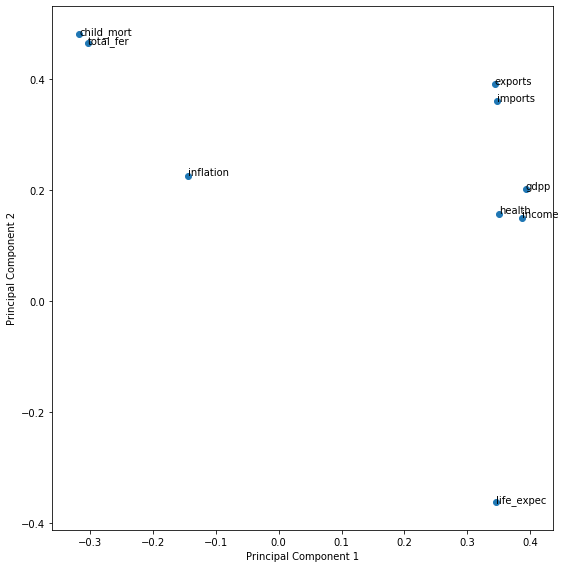

In [262]:
%matplotlib inline
fig = plt.figure(figsize = (8,8))
plt.scatter(pcs_df.PC1, pcs_df.PC2)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
for i, txt in enumerate(pcs_df.Feature):
    plt.annotate(txt, (pcs_df.PC1[i],pcs_df.PC2[i]))
plt.tight_layout()
plt.show()

#### Step 3.3:  Performing PCA with 3 components

In [263]:
pca_final = IncrementalPCA(n_components = 3)

In [264]:
X_pca = pca_final.fit_transform(X)
X_pca.shape

(167, 3)

In [265]:
len(y)

167

In [266]:
pca_final.explained_variance_ratio_

array([0.60229691, 0.17353447, 0.09739408])

In [267]:
df_pca = pd.DataFrame(X_pca)
df_pca.columns = ["PC1","PC2","PC3"]
df_pca.head()

,PC1,PC2,PC3
0,-2.706022,1.411739,-0.559990
1,-0.052914,-1.471043,0.007154
2,-0.485330,-0.697360,0.976802
3,-2.772196,2.150651,0.577639
4,0.678380,-1.010345,-0.236091


In [268]:
round(100*np.var(df_pca)/sum(np.var(df_pca)),4)

PC1    68.8054
PC2    19.8976
PC3    11.2970
dtype: float64

In [269]:
corrmat = np.corrcoef(X_pca.transpose())
corrmat.shape

(3, 3)

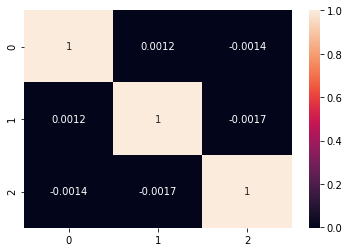

In [270]:
sns.heatmap(corrmat,annot=True)

In [271]:
100*np.var(df_pca)/sum(np.var(df_pca))

PC1    68.805350
PC2    19.897613
PC3    11.297036
dtype: float64

Maximum variance is explained by PC1 and all components seems not to be corelated with any other components.

## Step 4: Modelling with kMeans clustering

#### Step 4.1 Checking data compatibility with KMeans

In [272]:
#checking if the data is compatible for kmeans clustering
#Calculating the Hopkins statistic
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(data):
    d = data.shape[1]
    #d = len(vars) # columns
    n = len(data) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(data.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(data,axis=0),np.amax(data,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(data.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

hopkins(df_pca)

0.9169250017210439

Performed the Hopkins statistic, which basically gives us an idea, as to whether the dataset is good for clustering, or not.  Your obtained hopkins score is acceptable. Ideally, that value should be above 0.5, for the data to be assumed right for clustering. 

#### Step 4.2 Find out what should be the optimal number of clusters using SSD and silhouette score

([<matplotlib.axis.XTick at 0x2650dba4c88>,
 <a list of 7 Text xticklabel objects>)

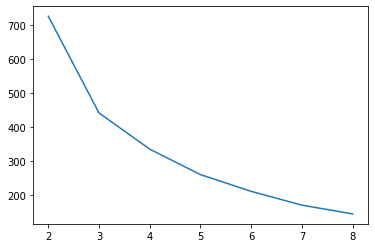

In [273]:
ssd = []
range_n_clusters = [2,3,4,5,6,7,8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters = num_clusters,max_iter = 50)
    kmeans.fit(X_pca)
    ssd.append(kmeans.inertia_)

plt.plot(ssd)
plt.xticks(np.arange(7), (2,3,4,5,6,7,8))

The above plot with elbow curve we can see that 3 or 4 clusters should be enough to create clusters of countries.
Lets do the silhouette analysis to further confirm the number of clusters.

For n_clusters=2, the silhouette score is 0.5021717478941314
For n_clusters=3, the silhouette score is 0.4799359749610031
For n_clusters=4, the silhouette score is 0.4802960691591883
For n_clusters=5, the silhouette score is 0.4869746143365451
For n_clusters=6, the silhouette score is 0.4081988501530789
For n_clusters=7, the silhouette score is 0.3987977125620216
For n_clusters=8, the silhouette score is 0.3943272910148628


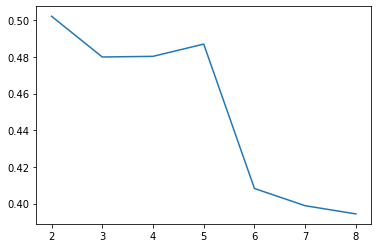

In [274]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
ss=[]
for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(X_pca)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(X_pca, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    ss.append([num_clusters, silhouette_avg])

plt.plot(pd.DataFrame(ss)[0],pd.DataFrame(ss)[1])
    

Considering k=4 for the final model as silhoutte score is max for k=5 (after k=2)

#### Step 4.3 Performing KMeans with chosen number of clusters

In [275]:
kMeans = KMeans(n_clusters = 5,max_iter = 50,random_state=42)
kMeans.fit(X_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [276]:
kMeans.labels_

array([4, 0, 0, 4, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 4, 0, 0, 0, 4,
       0, 1, 0, 4, 4, 0, 4, 1, 0, 4, 4, 0, 0, 0, 4, 4, 4, 0, 4, 0, 1, 1,
       1, 0, 0, 0, 0, 4, 4, 0, 0, 1, 1, 4, 4, 0, 1, 4, 1, 0, 0, 4, 4, 0,
       4, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 4, 4, 1, 0, 4, 0, 0, 4,
       4, 0, 0, 2, 0, 4, 4, 0, 0, 4, 1, 4, 0, 0, 0, 0, 0, 0, 4, 0, 4, 0,
       1, 1, 4, 3, 1, 0, 4, 0, 0, 0, 0, 0, 1, 1, 0, 0, 4, 0, 0, 4, 0, 0,
       4, 2, 1, 1, 4, 4, 1, 1, 0, 0, 4, 0, 1, 2, 0, 4, 0, 4, 4, 0, 0, 0,
       0, 4, 0, 1, 1, 1, 0, 0, 0, 0, 0, 4, 4])

We notice that the entire dataset is divided into 4 clusters with labels 0,1,2,3
Lets combine the labels with the pca transformed data to check how the clusters are formed.

In [277]:
df_pca['cluster_id'] = kMeans.labels_
df_pca.head()

,PC1,PC2,PC3,cluster_id
0,-2.706022,1.411739,-0.559990,4
1,-0.052914,-1.471043,0.007154,0
2,-0.485330,-0.697360,0.976802,0
3,-2.772196,2.150651,0.577639,4
4,0.678380,-1.010345,-0.236091,0


In [278]:
df_pca['cluster_id'].value_counts()

0    83
4    46
1    34
2     3
3     1
Name: cluster_id, dtype: int64

Lets see the visualization of our clusters based on PC1 and PC2

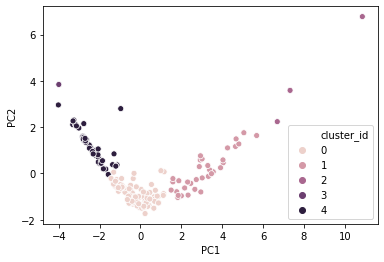

In [279]:
sns.scatterplot(x=df_pca["PC1"],y=df_pca["PC2"],hue=df_pca['cluster_id'],legend='full')

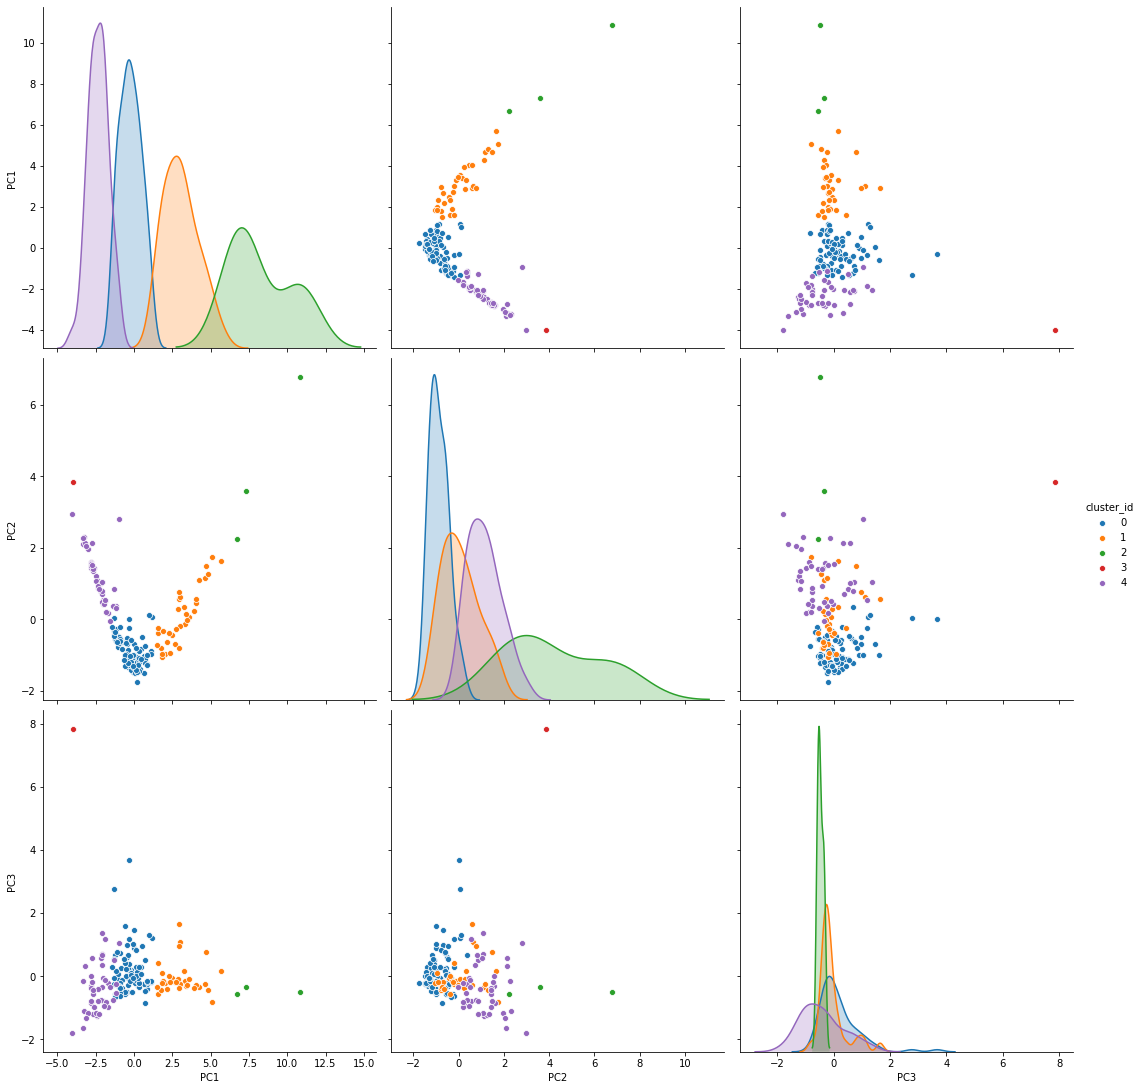

In [280]:
# lets see the pair plot of all Principal Components
sns.pairplot(data=df_pca, x_vars=["PC1","PC2","PC3"], y_vars=["PC1","PC2","PC3"], hue = "cluster_id", size=5)

The 5 clusters are clearly visible and are separated mainly on the basis of PC1 as PC1 captures the maximum variance in the data.

## Step 5: Cluster Profiling

Now lets combine the cluster labels to the original data so that we can perform analysis using the socio-economic factors.

In [281]:
df_kmeans_final = pd.concat([country_data,df_pca],axis=1)
df_kmeans_final.head()
df_kmeans_final.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,PC1,PC2,PC3,cluster_id
0,Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.44,56.2,5.82,553.0,-2.706022,1.411739,-0.559990,4
1,Albania,16.6,1145.20,267.8950,1987.740,9930.0,4.49,76.3,1.65,4090.0,-0.052914,-1.471043,0.007154,0
2,Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.10,76.5,2.89,4460.0,-0.485330,-0.697360,0.976802,0
3,Angola,119.0,2199.19,100.6050,1514.370,5900.0,22.40,60.1,6.16,3530.0,-2.772196,2.150651,0.577639,4
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.44,76.8,2.13,12200.0,0.678380,-1.010345,-0.236091,0


#### Step 5.1 Analysis based on the cluster ids

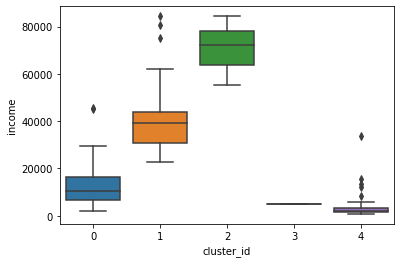

In [282]:
sns.boxplot(x='cluster_id', y='income', data=df_kmeans_final)

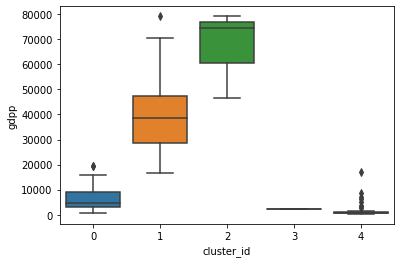

In [283]:
sns.boxplot(x='cluster_id', y='gdpp', data=df_kmeans_final)

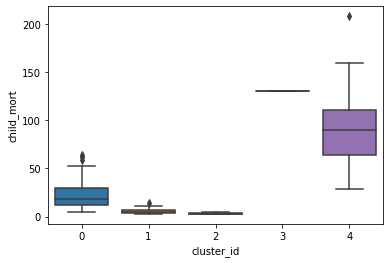

In [284]:
sns.boxplot(x='cluster_id', y='child_mort', data=df_kmeans_final)

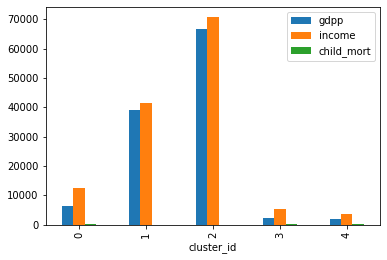

In [285]:
df_kmeans_final[['cluster_id','gdpp','income','child_mort']].groupby(by = 'cluster_id').mean().plot(kind='bar')

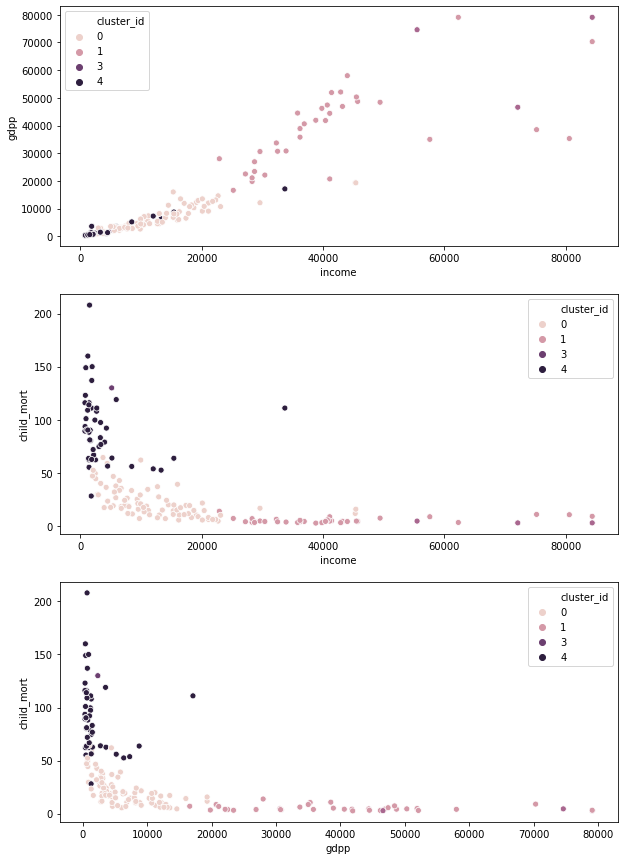

In [286]:
plt.figure(figsize=(10,15))
plt.subplot(3,1,1)
sns.scatterplot(x=df_kmeans_final["income"],y=df_kmeans_final["gdpp"],hue=df_kmeans_final['cluster_id'])
plt.subplot(3,1,2)
sns.scatterplot(x=df_kmeans_final["income"],y=df_kmeans_final["child_mort"],hue=df_kmeans_final['cluster_id'])
plt.subplot(3,1,3)
sns.scatterplot(x=df_kmeans_final["gdpp"],y=df_kmeans_final["child_mort"],hue=df_kmeans_final['cluster_id'])

#### Inferences:
- Countries with high income usually have high gdpp.
- Lower income and lower gdpp countries have very high child mortality rate
- The clusters are clearly visible in these plots

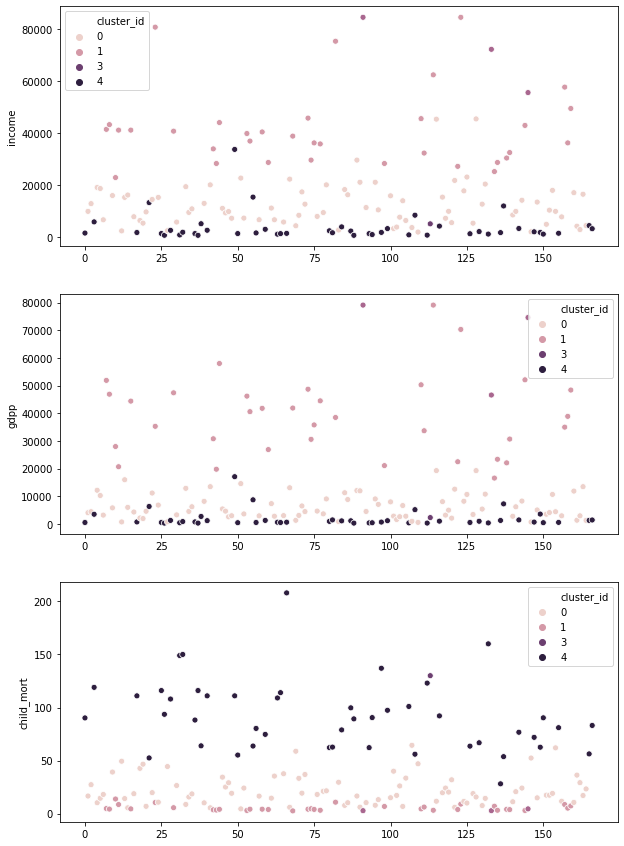

In [287]:
plt.figure(figsize=[10,15])
plt.subplot(3,1,1)
sns.scatterplot(y=df_kmeans_final["income"],x=df_kmeans_final.index,hue=df_kmeans_final['cluster_id'])
plt.subplot(3,1,2)
sns.scatterplot(y=df_kmeans_final["gdpp"],x=df_kmeans_final.index,hue=df_kmeans_final['cluster_id'])
plt.subplot(3,1,3)
sns.scatterplot(y=df_kmeans_final["child_mort"],x=df_kmeans_final.index,hue=df_kmeans_final['cluster_id'])
plt.show()

#### Inferences:
- There countries in cluster 2 and that seems to have very high income and very high gdpp with very low mortality rate 
- Countries in cluster 1 have high gdpp, high income and low mortality rate.
- Countries in cluster 0 have low income and low gdpp and a compaitively higher child mortality rate thaan countries in cluster 1 and 2
- Countries in cluster 3 and 4 have a very low income and very low gdpp. The child mortality rate seems to be very high.

Looking at the above analysis, we see that countries in cluster 3 and 4 are in need of financial aid


#### Step 5.2 Analysis of a particular cluster

In [288]:
df_kmeans_final[df_kmeans_final['cluster_id']==4].shape

(46, 14)

In [289]:
df_kmeans_final[df_kmeans_final['cluster_id']==3].shape

(1, 14)

There are total 47 countries which might need the aid.

In [290]:
cluster_4 = df_kmeans_final[df_kmeans_final["cluster_id"]==4]

In [291]:
cluster_4.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,PC1,PC2,PC3,cluster_id
count,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.0
mean,91.965217,866.139494,109.284365,821.764830,3682.575652,9.807283,59.039130,4.983043,1846.026957,-2.323934,1.143114,-0.417308,4.0
std,33.627464,2297.600735,164.296764,1569.620148,5550.665190,7.282140,6.410494,1.049383,2962.543223,0.650196,0.737113,0.753211,0.0
min,28.100000,23.087800,12.821200,112.306000,742.240000,0.885000,32.100000,2.590000,331.620000,-4.017004,-0.047087,-1.804777,4.0
25%,63.750000,102.121250,34.826025,192.802500,1390.000000,3.940000,56.575000,4.405000,548.500000,-2.778962,0.524097,-0.957148,4.0
50%,89.750000,188.290000,48.726500,315.996060,1835.000000,8.215000,59.400000,5.055000,833.000000,-2.319348,1.054206,-0.474529,4.0
75%,111.000000,446.625000,81.591000,701.122500,3310.000000,15.575000,62.650000,5.527500,1310.000000,-1.923657,1.549253,-0.057596,4.0
max,208.000000,14671.800000,766.080000,10071.900000,33700.000000,26.500000,71.100000,7.490000,17100.000000,-0.964865,2.957671,1.368866,4.0


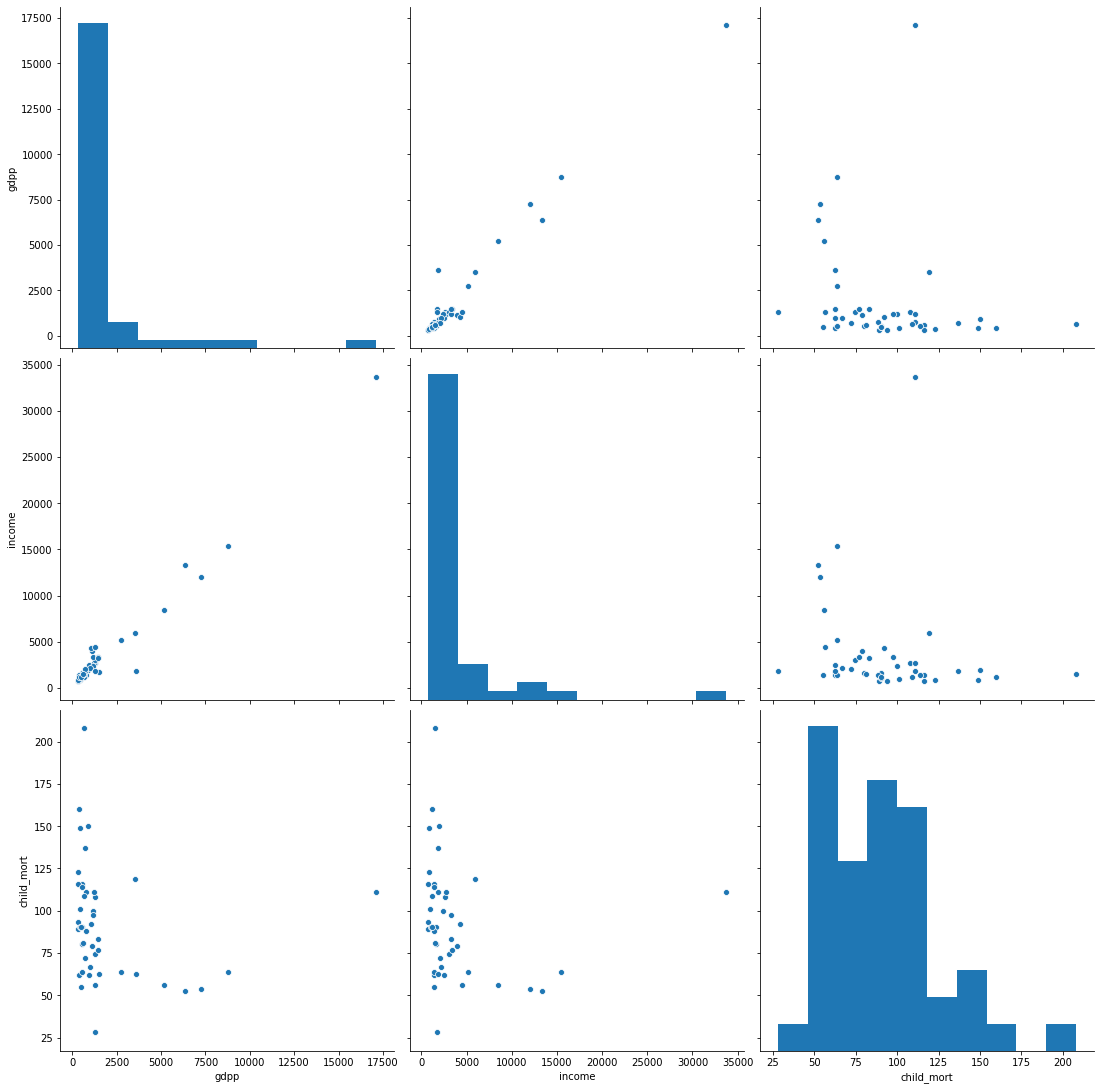

In [292]:
sns.pairplot(data = cluster_4,x_vars=['gdpp','income','child_mort'],y_vars=['gdpp','income','child_mort'],size=5)

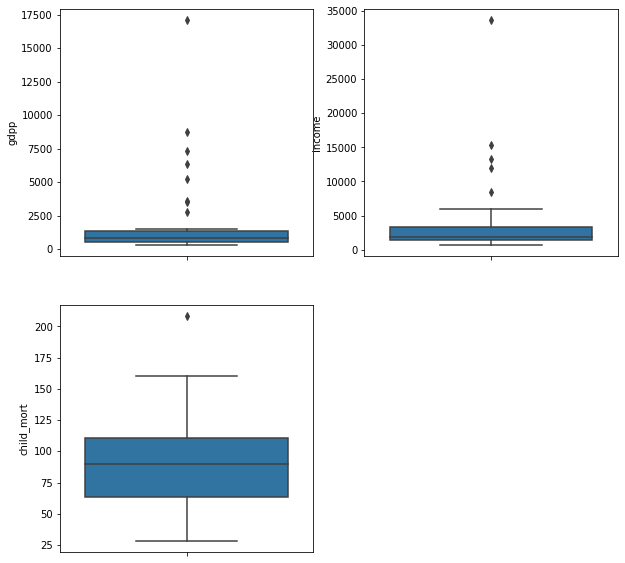

In [293]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
sns.boxplot(y=cluster_4['gdpp'])
plt.subplot(2,2,2)
sns.boxplot(y=cluster_4['income'])
plt.subplot(2,2,3)
sns.boxplot(y=cluster_4['child_mort'])
plt.show()

Inference:
   - Within this cluster there are countries which have very low income and very low gdpp which should be the top contenders for the aide.
   - The is a country which is an outlier in the child_mort. This country based in social need might need th aide.

In [294]:
cluster_4[['country','child_mort']][cluster_4['child_mort']>cluster_4['child_mort'].quantile(.99)]

,country,child_mort
66,Haiti,208.0


Lets sort the countries based on the socio-economic factors. The sort order is selected based on the importane of the factor. gdpp and income are given preference over child_mort rate.

In [295]:
cluster_4[['country','gdpp','income','child_mort']].sort_values(by=['gdpp','income','child_mort'],ascending = [True,True,False]).head(20)

,country,gdpp,income,child_mort
88,Liberia,331.62,742.24,89.3
26,Burundi,331.62,764.00,93.6
37,"Congo, Dem. Rep.",334.00,742.24,116.0
112,Niger,348.00,814.00,123.0
132,Sierra Leone,399.00,1220.00,160.0
93,Madagascar,413.00,1390.00,62.2
106,Mozambique,419.00,918.00,101.0
31,Central African Republic,446.00,888.00,149.0
94,Malawi,459.00,1030.00,90.5
50,Eritrea,482.00,1420.00,55.2


With kmeans clustering top 10 countries which are in need of help are 
- Liberia	
- Burundi	
- Congo, Dem. Rep.
- Niger	
- Sierra Leone
- Madagascar	
- Mozambique	
- Central African Republic	
- Malawi	
- Eritrea	

## Step 6: Modeling with Heirarchical Clustering

In [296]:
df_pca.head()

,PC1,PC2,PC3,cluster_id
0,-2.706022,1.411739,-0.559990,4
1,-0.052914,-1.471043,0.007154,0
2,-0.485330,-0.697360,0.976802,0
3,-2.772196,2.150651,0.577639,4
4,0.678380,-1.010345,-0.236091,0


In [297]:
df_heir = df_pca.drop(['cluster_id'],axis=1)
df_heir.head()

,PC1,PC2,PC3
0,-2.706022,1.411739,-0.559990
1,-0.052914,-1.471043,0.007154
2,-0.485330,-0.697360,0.976802
3,-2.772196,2.150651,0.577639
4,0.678380,-1.010345,-0.236091


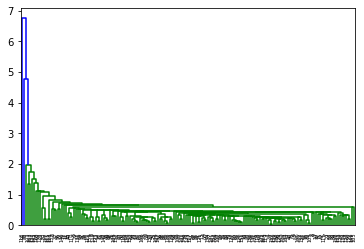

In [298]:
mergings = linkage(df_heir,method = 'single',metric='euclidean')
dendrogram(mergings)
plt.show()

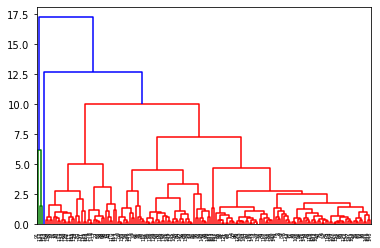

In [299]:
mergings_complete = linkage(df_heir,method = 'complete',metric='euclidean')
dendrogram(mergings_complete)
plt.show()

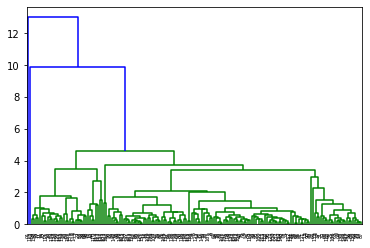

In [300]:
mergings_average = linkage(df_heir,method = 'average',metric='euclidean')
dendrogram(mergings_average)
plt.show()

Drawing a horizontal line at 7, will give 5 clusters with complete linkage method.

In [301]:
cluster_labels = cut_tree(mergings_complete,n_clusters=5).reshape(-1,)
cluster_labels

array([0, 1, 1, 0, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 2, 1, 0, 1, 1, 1, 0,
       1, 2, 1, 0, 0, 1, 0, 2, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 2, 2,
       2, 1, 1, 1, 1, 0, 0, 1, 1, 2, 2, 0, 0, 1, 2, 0, 2, 1, 1, 0, 0, 1,
       0, 1, 2, 1, 1, 1, 0, 2, 2, 2, 1, 2, 1, 1, 0, 0, 2, 1, 0, 1, 1, 0,
       0, 1, 1, 3, 1, 0, 0, 1, 1, 0, 2, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       2, 2, 0, 4, 2, 2, 0, 1, 1, 1, 1, 1, 2, 2, 1, 1, 0, 1, 2, 0, 1, 1,
       0, 3, 2, 2, 0, 0, 2, 2, 1, 1, 0, 1, 2, 3, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 2, 2, 2, 1, 1, 1, 1, 1, 0, 0])

In [302]:
df_heir['cluster_id'] = cluster_labels
df_heir.head()

,PC1,PC2,PC3,cluster_id
0,-2.706022,1.411739,-0.559990,0
1,-0.052914,-1.471043,0.007154,1
2,-0.485330,-0.697360,0.976802,1
3,-2.772196,2.150651,0.577639,0
4,0.678380,-1.010345,-0.236091,1


In [303]:
df_heir['cluster_id'].value_counts()

1    80
0    47
2    36
3     3
4     1
Name: cluster_id, dtype: int64

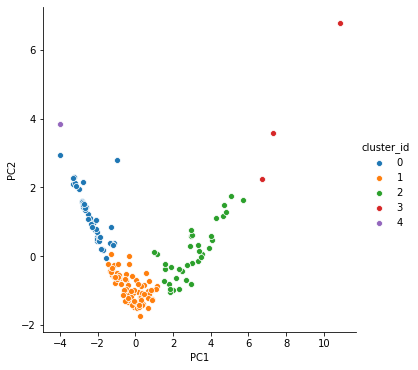

In [304]:
sns.pairplot(data=df_heir,x_vars="PC1",y_vars="PC2",hue='cluster_id',size=5)

Clusters formed are somewhat similar with KMeans but there is a slight overlap between the clusters 

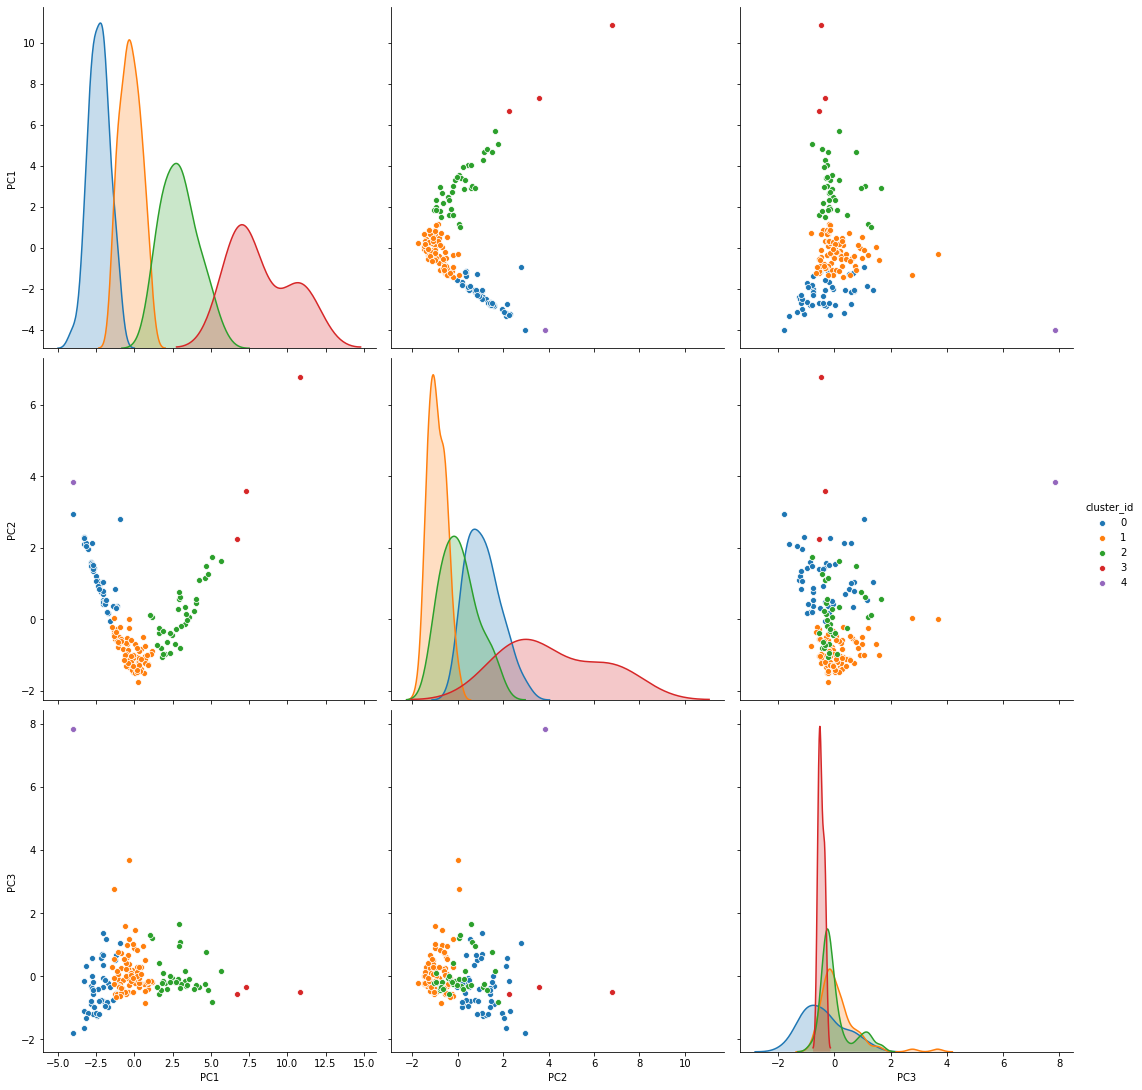

In [305]:
# lets see the pair plot of all Principal Components
sns.pairplot(data=df_heir, x_vars=["PC1","PC2","PC3"], y_vars=["PC1","PC2","PC3"], hue = "cluster_id", size=5)

In [306]:
df_heir_final = pd.concat([country_data,df_heir],axis=1)
df_heir_final.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,PC1,PC2,PC3,cluster_id
0,Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.44,56.2,5.82,553.0,-2.706022,1.411739,-0.559990,0
1,Albania,16.6,1145.20,267.8950,1987.740,9930.0,4.49,76.3,1.65,4090.0,-0.052914,-1.471043,0.007154,1
2,Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.10,76.5,2.89,4460.0,-0.485330,-0.697360,0.976802,1
3,Angola,119.0,2199.19,100.6050,1514.370,5900.0,22.40,60.1,6.16,3530.0,-2.772196,2.150651,0.577639,0
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.44,76.8,2.13,12200.0,0.678380,-1.010345,-0.236091,1


Cluster profiling

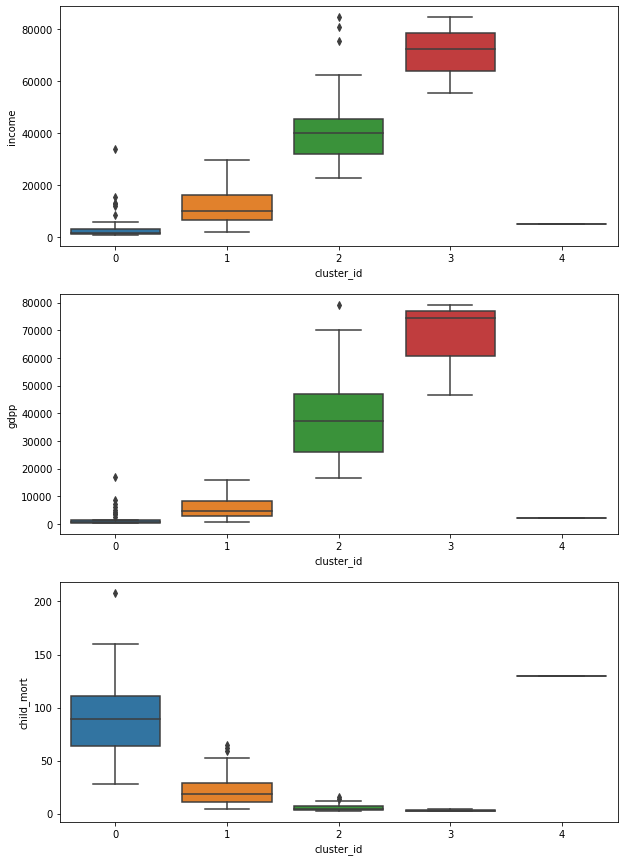

In [307]:
plt.figure(figsize=(10,15))
plt.subplot(3,1,1)
sns.boxplot(x='cluster_id', y='income', data=df_heir_final)
plt.subplot(3,1,2)
sns.boxplot(x='cluster_id', y='gdpp', data=df_heir_final)
plt.subplot(3,1,3)
sns.boxplot(x='cluster_id', y='child_mort', data=df_heir_final)

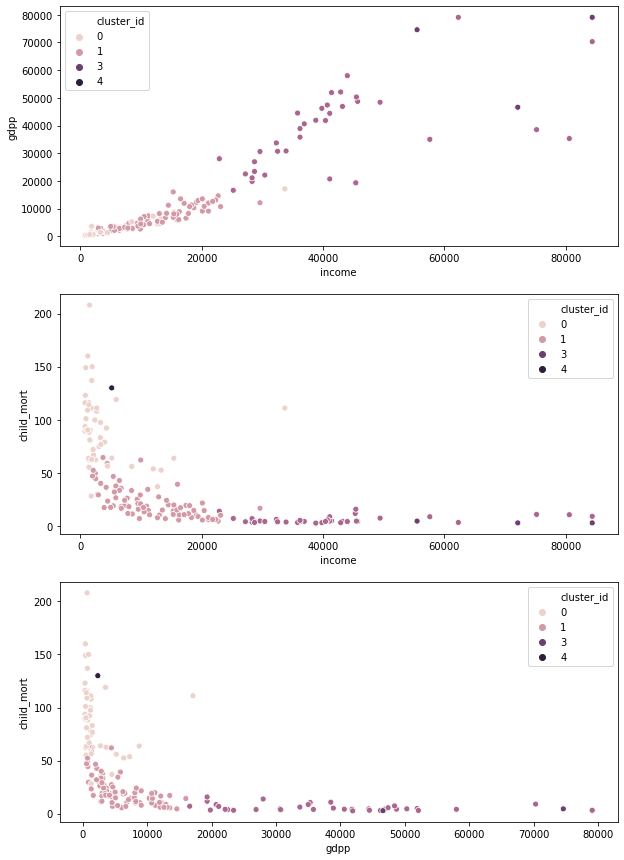

In [308]:
plt.figure(figsize=(10,15))
plt.subplot(3,1,1)
sns.scatterplot(x=df_heir_final["income"],y=df_heir_final["gdpp"],hue=df_heir_final['cluster_id'])
plt.subplot(3,1,2)
sns.scatterplot(x=df_heir_final["income"],y=df_heir_final["child_mort"],hue=df_heir_final['cluster_id'])
plt.subplot(3,1,3)
sns.scatterplot(x=df_heir_final["gdpp"],y=df_heir_final["child_mort"],hue=df_heir_final['cluster_id'])

In [309]:
df_heir_final[df_heir_final["cluster_id"]==4]

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,PC1,PC2,PC3,cluster_id
113,Nigeria,130.0,589.49,118.131,405.42,5150.0,104.0,60.5,5.84,2330.0,-3.99617,3.84219,7.839865,4


In [310]:
df_heir_final[df_heir_final["cluster_id"]==3]

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,PC1,PC2,PC3,cluster_id
91,Luxembourg,2.8,138404.0,6145.1376,112304.96,84374.0,3.620,81.3,1.63,79088.0,10.856576,6.775921,-0.490751,3
133,Singapore,2.8,93200.0,1845.3600,81084.00,72100.0,-0.046,82.7,1.15,46600.0,7.320790,3.587470,-0.348993,3
145,Switzerland,4.5,47744.0,8579.0000,39761.80,55500.0,0.317,82.2,1.52,74600.0,6.694256,2.235968,-0.562205,3


In [311]:
cluster_0 = df_heir_final[df_heir_final["cluster_id"]==0]

#### Inferences:
- There are 58 countries in cluster 0 with low income and low gdpp and high child mortality rate.
- Also one cluster i.e cluster 4 has only one country with low gdpp, low income and high mortality rate.
- There are just 4 countries in cluster 3 with very high income and very high gdpp
- There are 30 countries in cluster 2 which is also have high income and high gdpp and low mortality rate.

Better clusters were made with KMeans as there was a less overlap between clusters and were distinctively visible.


In [312]:
cluster_0[['country','gdpp','income','child_mort']].sort_values(by=['gdpp','income','child_mort'],ascending = [True,True,False]).head(10)

,country,gdpp,income,child_mort
88,Liberia,331.62,742.24,89.3
26,Burundi,331.62,764.00,93.6
37,"Congo, Dem. Rep.",334.00,742.24,116.0
112,Niger,348.00,814.00,123.0
132,Sierra Leone,399.00,1220.00,160.0
93,Madagascar,413.00,1390.00,62.2
106,Mozambique,419.00,918.00,101.0
31,Central African Republic,446.00,888.00,149.0
94,Malawi,459.00,1030.00,90.5
50,Eritrea,482.00,1420.00,55.2


Though the cluster are formed differently with KMeans and Hierarchical Clustering, the top 9 countries which seems to be in direst need of aid are the same. The CEO needs to focus on the following 9 countries

- Liberia	
- Burundi	
- Congo, Dem. Rep.
- Niger	
- Sierra Leone
- Madagascar	
- Mozambique	
- Central African Republic	
- Malawi	
